要模拟一个情景，其中有600个人站成一排，每次随机杀掉一个奇数位置的人，目的是找出哪个位置的人最安全。具体实现可以分为以下几个步骤和解释：

### 1. 问题理解

- **初始状态**：有600个人站成一排，编号从1到600。
- **杀人规则**：每一轮中，随机选择当前存活的奇数编号的人，杀掉他们。
- **最终目标**：运行多次模拟，统计每个人被杀的轮次，找出哪些编号的人最晚被杀，或者可能存活到最后。

### 2. 实现思路

实现的关键在于通过多次模拟，记录每个编号的人在每次模拟中被杀的轮次，然后通过统计找到最安全的位置。

### 3. 关键步骤解释

1. **`random_kill(n)` 和 `random_kill_list(alive_ids)` 函数**：
   - `random_kill(n)`：在给定范围内随机选择一个奇数位置的人。
   - `random_kill_list(alive_ids)`：从当前存活的人中，选择一个奇数位置的人进行淘汰。

2. **`run_simulation_numpy(num_people)` 函数**：
   - `ids`：表示所有人的编号，从1到600。
   - `status`：表示每个人的生存状态，1表示存活，0表示被淘汰。
   - `killed_turn`：记录每个人被淘汰的回合，初始值为-1表示尚未被淘汰。
   - 每轮循环中，`alive_ids`会筛选出当前存活的编号，然后随机淘汰其中一个奇数编号的人。
   - 淘汰后更新 `status` 和 `killed_turn`，最后将结果存储在一个DataFrame中。

3. **多次模拟**：
   - 通过循环运行 `run_simulation_numpy(num_people)` N次（例如20000次），在每次模拟中记录每个人的淘汰回合。
   - 结果存储在 `df_simul` DataFrame中，每一列表示一次模拟的结果。



In [265]:
import pandas as pd
import numpy as np
import random
import warnings
import seaborn as sns
from pylab import mpl, plt

# best font and style settings for notebook
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = '微软雅黑'
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook


def random_kill(n):
    # 生成一个随机的奇数，范围从0到n-1
    return random.choice([i for i in range(n) if i % 2 == 0])


def random_kill_list(alive_ids):
    n = len(alive_ids)
    return alive_ids[random_kill(n)]


def run_simulation_numpy(num_people):

    # 初始化 NumPy 数组
    ids = np.arange(1, num_people + 1)
    killed_turn = np.full(num_people, -1)  # 初始化淘汰回合
    turn_num = num_people

    for turn in range(turn_num):
        alive_ids = ids[killed_turn == -1]  # 获取当前存活的ID
        if len(alive_ids) == 0:  # 如果没有存活者，提前退出循环
            break

        kill_id = random_kill_list(alive_ids) - 1  # 选择要淘汰的ID

        killed_turn[kill_id] = turn + 1  # 记录淘汰回合

    return killed_turn

#
num_people = 600
N = 50000
df_simul = pd.DataFrame({"id": range(1, 1 + num_people)})
for i in tqdm_notebook(range(N)):
    result_df = run_simulation_numpy(num_people)
    df_simul[f'turn_{i}'] = result_df


  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
df_simul.min().iloc[:-1].sum()

5000

In [ ]:
df_simul.iloc[df_simul.iloc[:,1:].idxmax()]

,id,turn_0,turn_1,turn_2,turn_3,turn_4,turn_5,turn_6,turn_7,turn_8,...,turn_4990,turn_4991,turn_4992,turn_4993,turn_4994,turn_4995,turn_4996,turn_4997,turn_4998,turn_4999
218,219,600,257,88,406,422,275,283,456,566,...,402,216,401,41,563,25,359,36,537,482
335,336,350,600,400,593,286,288,501,515,230,...,441,257,33,52,69,433,304,390,251,474
246,247,275,54,600,83,275,80,300,19,119,...,229,1,80,64,202,163,74,245,21,419
559,560,382,280,271,600,463,123,508,156,296,...,535,528,402,394,198,46,503,530,141,370
413,414,553,346,368,425,600,154,423,478,290,...,582,450,563,497,192,305,136,600,527,583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,461,174,206,139,140,107,142,114,340,342,...,309,219,383,350,30,600,4,127,226,161
599,600,98,574,154,468,486,60,294,330,236,...,256,410,540,62,548,108,600,54,168,554
413,414,553,346,368,425,600,154,423,478,290,...,582,450,563,497,192,305,136,600,527,583
389,390,272,353,342,463,117,91,563,147,405,...,116,46,385,427,224,70,97,373,600,466


,id,win_count
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
595,596,21
596,597,12
597,598,14
598,599,19


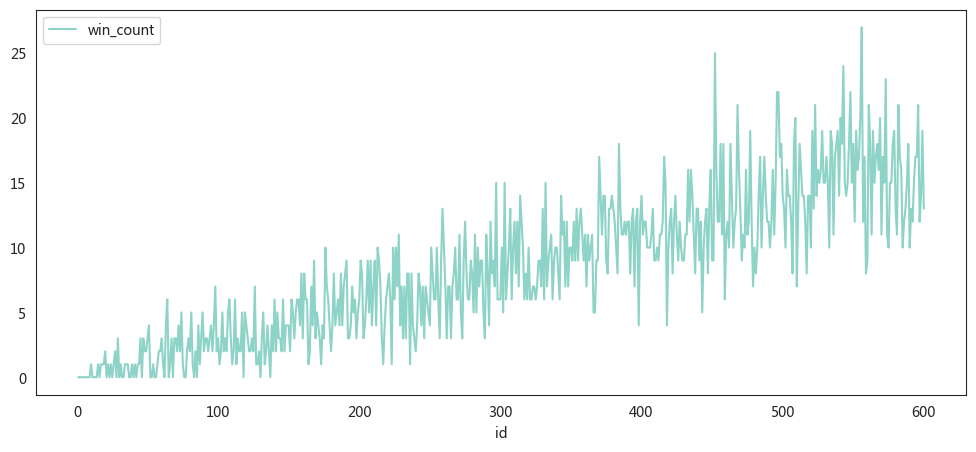

In [ ]:
a = df_simul.iloc[:, 1:].idxmax().values + 1
b = np.array(range(1, 1 + num_people))
# pd.DataFrame(np.concatenate((a, b))).value_counts().sort_index().values - 1

last_killed_counts = pd.DataFrame({
    'id':
    b,
    'win_count':
    pd.DataFrame(np.concatenate((a, b))).value_counts().sort_index().values - 1
})
last_killed_counts.plot(x='id', y='win_count', figsize=(12, 5))
last_killed_counts

In [ ]:
last_killed_counts.sort_values('win_count',ascending=False)

,id,win_count
555,556,27
451,452,25
542,543,24
572,573,23
495,496,22
...,...,...
37,38,0
36,37,0
32,33,0
31,32,0


In [ ]:
df_simul['average_alive_turns'] = df_simul.T.mean()
df_simul[['id', 'average_alive_turns']].sort_values(by='average_alive_turns',
                                                    ascending=False)

,id,average_alive_turns
1,2,331.908818
3,4,324.174965
11,12,316.400320
5,6,316.315937
7,8,313.761648
...,...,...
8,9,285.386123
6,7,278.004199
4,5,266.746251
2,3,249.878624


<AxesSubplot:xlabel='id'>

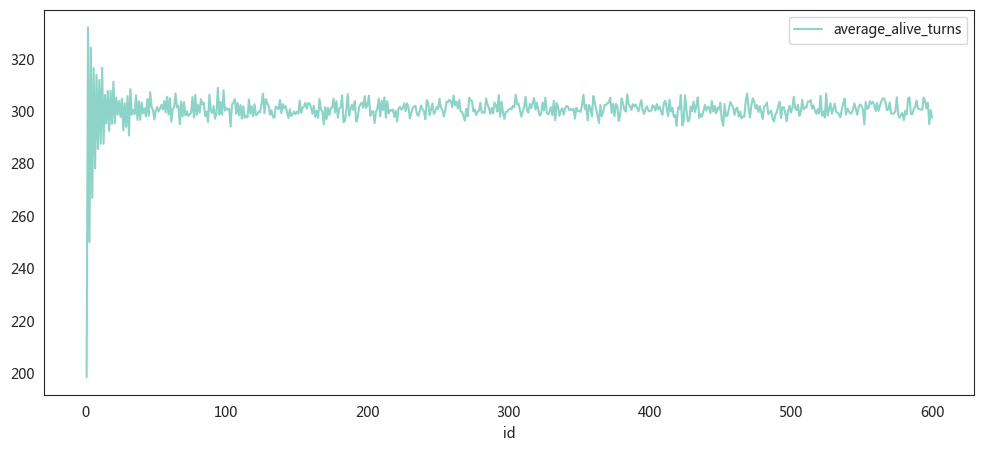

In [ ]:
df_simul[['id', 'average_alive_turns']].plot(x='id',y='average_alive_turns',figsize=(12,5))

In [ ]:
!jupyter nbconvert --to html random_kill_final.ipynb

[NbConvertApp] Converting notebook random_kill_final.ipynb to html
[NbConvertApp] Writing 443576 bytes to random_kill_final.html


In [ ]:
!jupyter nbconvert --to markdown random_kill_final.ipynb

[NbConvertApp] Converting notebook random_kill_final.ipynb to markdown
[NbConvertApp] Support files will be in random_kill_final_files/
[NbConvertApp] Writing 14356 bytes to random_kill_final.md
